# **NB 5.3: Sentiment Analysis Over time - After BERT Topic Modeling**

In [101]:
# Standard Inputs

import sklearn
import os
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn import metrics

from joblib import dump, load
from joblib import Parallel, delayed

In [6]:
# Multiprocessing

#pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False, progress_bar=True )

Available CPUs: 16
INFO: Pandarallel will run on 15 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [7]:
# Imports the Google Cloud client library

from google.cloud import storage
# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "nlp_final_project_kshitijm"

# Creates the new bucket
bucket = storage_client.bucket(bucket_name)
print(f"Bucket {bucket.name} connected.")

Bucket nlp_final_project_kshitijm connected.


In [26]:
#Visuals

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('white')
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

import warnings
warnings.filterwarnings("ignore")

## Importing data files

In [9]:
%%time

### Loading positive and negative sentiment datasets

df_filt_pos=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_POS_BERTopics_Sentiments_NER.csv',lineterminator='\n')
df_filt_neg=pd.read_csv('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data7_NEG_BERTopics_Sentiments_NER.csv',lineterminator='\n')

CPU times: user 43.2 s, sys: 8.9 s, total: 52.1 s
Wall time: 2min 14s


In [36]:
%%time

### Loading an older data file with all articles
df4_samp=pd.read_parquet('gs://nlp_final_project_kshitijm/00_Data/NLP_FP_Data4_filtered.parquet')


CPU times: user 1min 10s, sys: 1min 1s, total: 2min 12s
Wall time: 2min 1s


In [55]:
articles_period=df4_samp.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
articles_period.rename(columns={'url':'count_total_articles'}, inplace=True)
articles_period[0:5]

,year_pub,month,month-year,count_total_articles
0,2020,1,Jan 2020,2886
1,2020,2,Feb 2020,2745
2,2020,3,Mar 2020,3083
3,2020,4,Apr 2020,2961
4,2020,5,May 2020,2910


In [54]:
pos_articles_period=df_filt_pos.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_articles_period.rename(columns={'url':'count_pos_articles'}, inplace=True)
pos_articles_period[0:5]

,year_pub,month,month-year,count_pos_articles
0,2020,1,Jan 2020,876
1,2020,2,Feb 2020,748
2,2020,3,Mar 2020,936
3,2020,4,Apr 2020,869
4,2020,5,May 2020,764


In [53]:
neg_articles_period=df_filt_neg.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
neg_articles_period.rename(columns={'url':'count_neg_articles'}, inplace=True)
neg_articles_period[0:5]

,year_pub,month,month-year,count_neg_articles
0,2020,1,Jan 2020,79
1,2020,2,Feb 2020,76
2,2020,3,Mar 2020,71
3,2020,4,Apr 2020,48
4,2020,5,May 2020,58


In [64]:
articles_sents=articles_period.merge(pos_articles_period['count_pos_articles'], left_on=articles_period['month-year'], right_on=pos_articles_period['month-year'], how='left')
articles_sents.drop(['key_0'], axis=1, inplace=True)
articles_sents=articles_sents.merge(neg_articles_period['count_neg_articles'], on=articles_sents['month-year'], how='left')
articles_sents.drop(['key_0'], axis=1, inplace=True)

articles_sents['prop_pos_articles']=np.round((articles_sents['count_pos_articles']/articles_sents['count_total_articles'])*100,2)
articles_sents['prop_neg_articles']=np.round((articles_sents['count_neg_articles']/articles_sents['count_total_articles'])*100,2)

articles_sents
# articles_sents.merge(neg_articles_period['count_neg_articles'], on=articles_sents['month-year'], how='left')

,year_pub,month,month-year,count_total_articles,count_pos_articles,count_neg_articles,prop_pos_articles,prop_neg_articles
0,2020,1,Jan 2020,2886,876,79,30.35,2.74
1,2020,2,Feb 2020,2745,748,76,27.25,2.77
2,2020,3,Mar 2020,3083,936,71,30.36,2.30
3,2020,4,Apr 2020,2961,869,48,29.35,1.62
4,2020,5,May 2020,2910,764,58,26.25,1.99
5,2020,6,Jun 2020,1786,525,35,29.40,1.96
6,2020,7,Jul 2020,2073,567,53,27.35,2.56
7,2020,8,Aug 2020,2191,614,49,28.02,2.24
8,2020,9,Sep 2020,2634,797,43,30.26,1.63
9,2020,10,Oct 2020,3170,958,48,30.22,1.51


In [100]:
articles_sents.to_csv('articles_sents.csv')

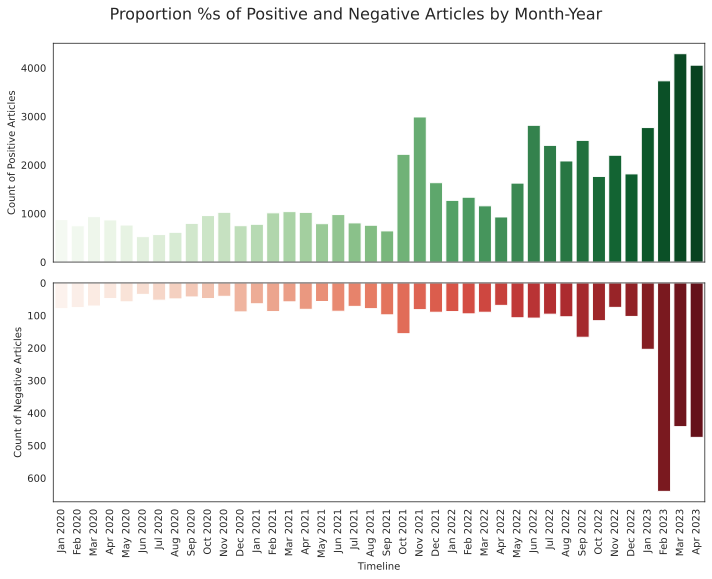

In [97]:
fig,axes=plt.subplots(2,1,figsize=(10, 8), sharex=True)
axes=axes.flatten()

green_palette = sns.color_palette('Greens', n_colors=len(articles_sents['month-year'].unique()))
red_palette = sns.color_palette('Reds', n_colors=len(articles_sents['month-year'].unique()))

sns.barplot(x=articles_sents['month-year'],y=articles_sents['count_pos_articles'], ax=axes[0], palette=green_palette)
sns.barplot(x=articles_sents['month-year'],y=articles_sents['count_neg_articles'], ax=axes[1], palette=red_palette)

plt.xticks(rotation=90)

axes[0].set_ylabel('Count of Positive Articles')
axes[0].set_xlabel('')  # Remove x-axis label from the upper subplot

# axes[0].set_title('Postitive Articles Count by Month-Year')
# axes[0].set_xlabel('Count of Positive Articles')


axes[1].set_ylabel('Count of Negative Articles')
axes[1].set_xlabel('Timeline')

# axes[1].set_title('Negative Articles Count by Month-Year')
axes[1].invert_yaxis()

fig.suptitle('Counts of Positive and Negative Articles by Month-Year', fontsize=16, y=1)

# Show the plot
plt.tight_layout()
plt.show()

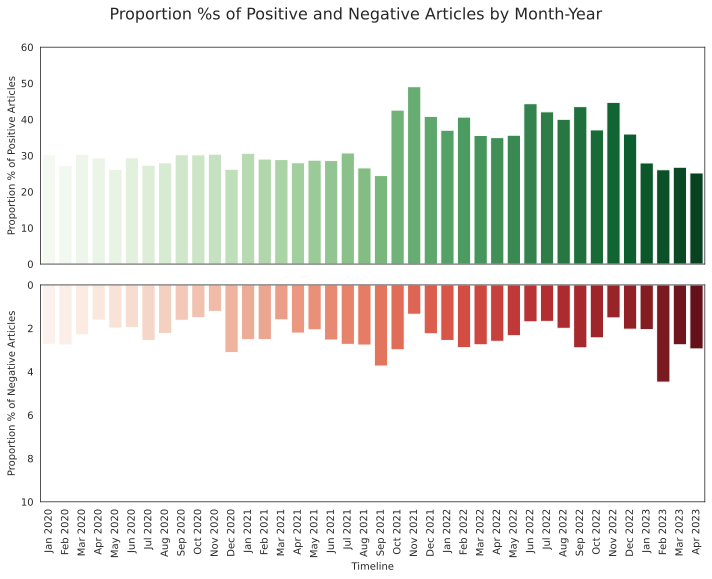

In [99]:
fig,axes=plt.subplots(2,1,figsize=(10, 8), sharex=True)
axes=axes.flatten()

green_palette = sns.color_palette('Greens', n_colors=len(articles_sents['month-year'].unique()))
red_palette = sns.color_palette('Reds', n_colors=len(articles_sents['month-year'].unique()))

sns.barplot(x=articles_sents['month-year'],y=articles_sents['prop_pos_articles'], ax=axes[0], palette=green_palette)
sns.barplot(x=articles_sents['month-year'],y=articles_sents['prop_neg_articles'], ax=axes[1], palette=red_palette)

plt.xticks(rotation=90)

axes[0].set_ylabel('Proportion % of Positive Articles')
axes[0].set_xlabel('')  # Remove x-axis label from the upper subplot
axes[0].set_ylim(0, 60)  # Set y-axis limits for the upper subplot

# axes[0].set_title('Postitive Articles Count by Month-Year')
# axes[0].set_xlabel('Count of Positive Articles')


axes[1].set_ylabel('Proportion % of Negative Articles')
axes[1].set_xlabel('Timeline')
axes[1].set_ylim(0, 10)  # Set y-axis limits for the lower subplot

# axes[1].set_title('Negative Articles Count by Month-Year')
axes[1].invert_yaxis()

fig.suptitle('Proportion %s of Positive and Negative Articles by Month-Year', fontsize=16, y=1)


# Show the plot
plt.tight_layout()
plt.show()

----
### Checking for Positive and Negative Topics as obtained from BERT

In [107]:
pd.options.display.max_colwidth=500
df_filt_pos[['Bert_topics','Bert_topics_words']]

,Bert_topics,Bert_topics_words
0,-1,"[('ai', 0.0032932909267568665), ('gray', 0.0028249496130194913), ('media', 0.0028206367957601614), ('data', 0.0027981886977514045), ('new', 0.0027387487958585), ('technology', 0.0026908933936764436), ('platform', 0.0026408861098344634), ('group', 0.002625863466055733), ('news', 0.0024182299091693184), ('press', 0.0024127418231146146)]"
1,5,"[('customer', 0.020242565150814632), ('conversational', 0.014569233002309397), ('experience', 0.009351522323637635), ('agents', 0.008735525595475238), ('laivly', 0.008062035975213143), ('marketing', 0.007513518101372803), ('customers', 0.006692537628556562), ('cx', 0.006641168866439065), ('service', 0.006432564034051842), ('chatbots', 0.006378357010834833)]"
2,52,"[('aviation', 0.06603324426035537), ('xo', 0.034962207391804945), ('aircraft', 0.018392493105208536), ('private', 0.012422535511524108), ('airlines', 0.012259519568346956), ('flights', 0.012119659857380569), ('asset', 0.010560825354304885), ('air', 0.010559563121351812), ('xos', 0.010222073633489679), ('fleet', 0.009970265619687781)]"
3,-1,"[('ai', 0.0032932909267568665), ('gray', 0.0028249496130194913), ('media', 0.0028206367957601614), ('data', 0.0027981886977514045), ('new', 0.0027387487958585), ('technology', 0.0026908933936764436), ('platform', 0.0026408861098344634), ('group', 0.002625863466055733), ('news', 0.0024182299091693184), ('press', 0.0024127418231146146)]"
4,50,"[('breast', 0.04530666017313565), ('cancer', 0.03760578342005783), ('mammograms', 0.02002199889407515), ('radiologists', 0.015451543302269388), ('screening', 0.013901173189557582), ('false', 0.013143847317707624), ('women', 0.012746877633190828), ('doctors', 0.011133508172294491), ('mammography', 0.009735290522339428), ('cancers', 0.008913050933978402)]"
...,...,...
60876,141,"[('kr', 0.0596032523971753), ('production', 0.022882050752662295), ('interaction', 0.022519126301682724), ('content', 0.0212830583185128), ('krs', 0.01807678675925623), ('krkr', 0.017108662270559717), ('user', 0.01646109412803668), ('chatgpt', 0.014776942632425861), ('companys', 0.014247356745103567), ('aigc', 0.014025790856166004)]"
60877,108,"[('cujo', 0.07302244111018388), ('onsolve', 0.05835369782797956), ('infosec', 0.04289504020630474), ('rsa', 0.028549129680539322), ('cybersecurity', 0.028276395463641423), ('awards', 0.027919445379301532), ('security', 0.021552032479921095), ('segmed', 0.021416194290133445), ('astor', 0.019896795958577657), ('synthetic', 0.016490009712703087)]"
60878,-1,"[('ai', 0.0032932909267568665), ('gray', 0.0028249496130194913), ('media', 0.0028206367957601614), ('data', 0.0027981886977514045), ('new', 0.0027387487958585), ('technology', 0.0026908933936764436), ('platform', 0.0026408861098344634), ('group', 0.002625863466055733), ('news', 0.0024182299091693184), ('press', 0.0024127418231146146)]"
60879,191,"[('code', 0.029858359673178098), ('uol', 0.0293709563439113), ('compass', 0.029095848053289443), ('developers', 0.027420190873795325), ('github', 0.020114188473345077), ('copilot', 0.019350303493669174), ('kite', 0.018834250326753104), ('lowcode', 0.018323639565668588), ('programming', 0.014935886688139487), ('python', 0.014925307239330757)]"


In [105]:
# Topic 4 - Conversational AI

In [109]:
df_filt_pos_convai=df_filt_pos[df_filt_pos.Bert_topics==4]
df_filt_pos_convai.sample(2)

,Unnamed: 0.1,Unnamed: 0,url,date,language,title,text,cleaned_text,article_source,clean_title,...,sent_probs,sent_label,entities_spacy,ENT_ORG,ENT_PROD,ENT_PER,ENT_NORP,cleaned_tokens_string,Bert_topics,Bert_topics_words
37652,NaN,34240,https://exbulletin.com/tech/1787479/,2022-08-08,en,"Meta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays ahead - ExBulletin","Meta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays ahead - ExBulletin \n \n\nEntertainmentPoliticsFashionSportsTechBusinessContact Us!\nConnect with us\n\nExBulletinMeta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays aheadEntertainmentPoliticsFashionSportsTechBusinessContact Us!\nTechMeta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays ahead\nPublished 20 seconds agoon August 8, 2022By NewsDesk \n \n \n Meta understood early on that ...","Meta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays Us Connect with us ExBulletinMeta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays Us TechMeta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays ahead Published 20 seconds agoon August 8, 2022By NewsDeskMeta understood early on that language models perform better when learned from chatting with people.This experience helps the model understand based on the feedback it gets from usersMeta under...",ExBulletin,"Meta Facebook puts AI chatbot BlenderBot 3 to the test, Google stays ahead",...,[[3.0649517e-04 4.7763124e-02 9.5193040e-01]],2,"[('Meta Facebook', 'ORG'), ('AI', 'PRODUCT'), ('BlenderBot', 'PRODUCT'), ('Google', 'ORG'), ('Us Connect', 'ORG'), ('AI', 'PRODUCT'), ('BlenderBot', 'PRODUCT'), ('Google', 'ORG'), ('Us TechMeta Facebook', 'PRODUCT'), ('AI', 'PRODUCT'), ('BlenderBot', 'PRODUCT'), ('Google', 'ORG'), ('20 seconds', 'TIME'), ('August 8', 'DATE'), ('2022By', 'CARDINAL'), ('NewsDeskMeta', 'GPE'), ('Meta', 'ORG'), ('AI', 'PRODUCT'), ('Friday', 'DATE'), ('BlenderBot 3', 'PRODUCT'), ('AI', 'PRODUCT'), ('third', 'ORDI...","['Meta Facebook', 'Google', 'Us Connect', 'Google', 'Google', 'Meta', 'GPT3', 'Facebooks', 'Meta', 'Facebook', 'AI', 'OpenAI', 'Facebook', 'Googles', 'Google', 'GPT3', 'moneysaving', 'Internet Marketing Company', 'NTA', 'TC', 'Magnum PI', '2022Alarm', '2022Tweets', 'bulletin_ex and', 'Home']","['AI', 'BlenderBot', 'AI', 'BlenderBot', 'Us TechMeta Facebook', 'AI', 'BlenderBot', 'AI', 'BlenderBot 3', 'AI', 'BlenderBot', 'BlenderBot 3', 'AI', 'Language Skills Improve', 'NLP']","['BlendBot', 'Googles Meena', 'Russell Rabichev', 'Erdogan', 'Earl Mosley']",['Western'],meta facebook puts ai chatbot blenderbot test google stays connect exbulletinmeta facebook puts ai chatbot blenderbot test google stays techmeta facebook puts ai chatbot blenderbot test google stays ahead published seconds agoon august newsdeskmeta understood early language models perform better learned chatting people experience helps model understand based feedback gets usersmeta understood early language models perform better learned chatting people experience helps model understand based...,4,"[('chatgpt', 0.024484472185365494), ('gpt', 0.018853506230723568), ('openai', 0.015101798974842326), ('chatbot', 0.009455174578377171), ('users', 0.006181359642835977), ('model', 0.00566984975499988), ('text', 0.0055434445039397205), ('openais', 0.00554112058699134), ('language', 0.005218961455510245), ('google', 0.004935867148259107)]"
50163,NaN,15066,https://www.augustman.com/in/gear/tech/openai-gpt-chatbot-chatgpt-dark-side/,2023-02-01,en,ChatGPT: Exploring The Dark Side Of OpenAI's GPT Chatbot,\nChatGPT: Exploring The Dark Side Of OpenAI's GPT Chatbot\n\n \nIN\n\n\nSG\n\n\nMY\n\n\nTH\n\n\nHK\n\nStyle\n\n\nFashion\n\n\nGrooming\n\n\nWatches\n\nCulture\n\n\nArt\n\n\nDesign\n\n\nEvents\n\n\nFilm & TV\n\n\nLiving\n\n\nMusic\n\nGear\n\n\nMotoring\n\n\nTech\n\nFood & Drink\n\n\nDining\n\n\nDrinks\n\nTravel\n\n\nHotels & Resorts\n\n\nTravel Guides\n\nWellness\n\n\nFitness\n\n\nHealth\n\nAM Select\n\n\nA

In [110]:
pos_convai_period=df_filt_pos_convai.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_convai_period.rename(columns={'url':'count_articles'}, inplace=True)

In [111]:
pos_convai_period

,year_pub,month,month-year,count_articles
0,2020,3,Mar 2020,1
1,2020,4,Apr 2020,3
2,2020,5,May 2020,1
3,2020,6,Jun 2020,3
4,2020,7,Jul 2020,1
5,2020,9,Sep 2020,2
6,2020,10,Oct 2020,1
7,2020,12,Dec 2020,1
8,2021,3,Mar 2021,2
9,2021,4,Apr 2021,1


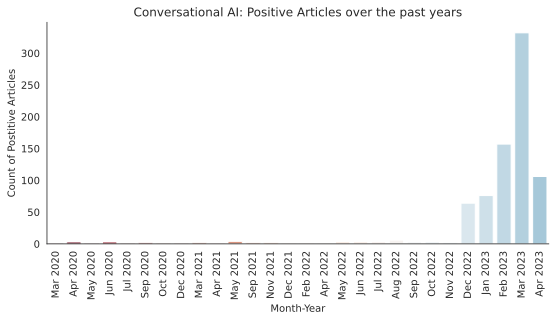

In [139]:
fig,axes=plt.subplots(figsize=(9, 4))
RdBu_palette = sns.color_palette('RdBu', n_colors=len(articles_sents['month-year'].unique()))

sns.barplot(x=pos_convai_period['month-year'],y=pos_convai_period['count_articles'], ax=axes, palette = RdBu_palette)


plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Postitive Articles')
plt.title('Conversational AI: Positive Articles over the past years')

sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/convai_pos.png')

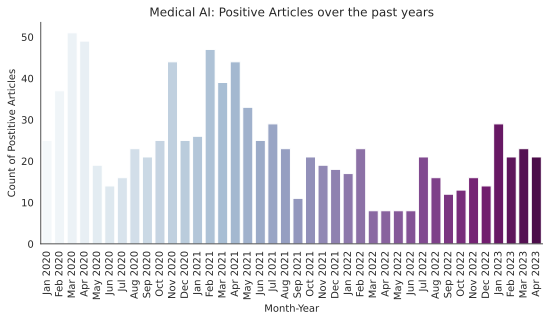

In [140]:
#Healthcare

df_filt_pos_medai=df_filt_pos[df_filt_pos.Bert_topics==2]
pos_medai_period=df_filt_pos_medai.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_medai_period.rename(columns={'url':'count_articles'}, inplace=True)

bupu_palette = sns.color_palette('BuPu', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(9, 4))
sns.barplot(x=pos_medai_period['month-year'],y=pos_medai_period['count_articles'], ax=axes, palette=bupu_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Postitive Articles')
plt.title('Medical AI: Positive Articles over the past years')
sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/medai_pos.png')

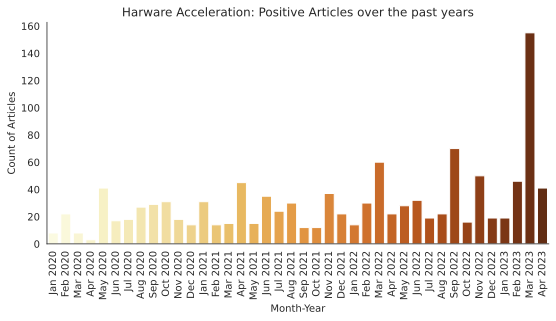

In [141]:
# Processing Hardware

df_filt_pos_gpu=df_filt_pos[df_filt_pos.Bert_topics.isin([6,7])]
pos_gpu_period=df_filt_pos_gpu.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_gpu_period.rename(columns={'url':'count_articles'}, inplace=True)

YlOrBr_palette = sns.color_palette('YlOrBr', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(9, 4))
sns.barplot(x=pos_gpu_period['month-year'],y=pos_gpu_period['count_articles'], ax=axes, palette=YlOrBr_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Articles')
plt.title('Harware Acceleration: Positive Articles over the past years')
sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/gpu_pos.png')

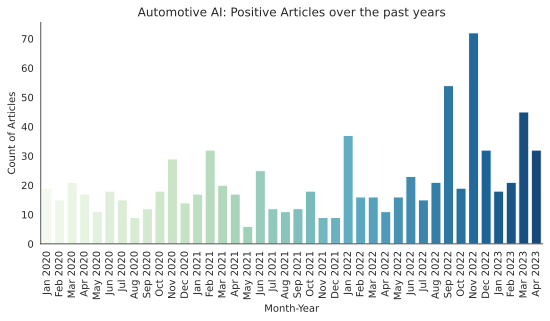

In [142]:
# Automotive Sector

df_filt_pos_auto=df_filt_pos[df_filt_pos.Bert_topics.isin([3])]
pos_auto_period=df_filt_pos_auto.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_auto_period.rename(columns={'url':'count_articles'}, inplace=True)

GnBu_palette = sns.color_palette('GnBu', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(9, 4))
sns.barplot(x=pos_auto_period['month-year'],y=pos_auto_period['count_articles'], ax=axes, palette=GnBu_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Articles')
plt.title('Automotive AI: Positive Articles over the past years')
sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/autoai_pos.png')

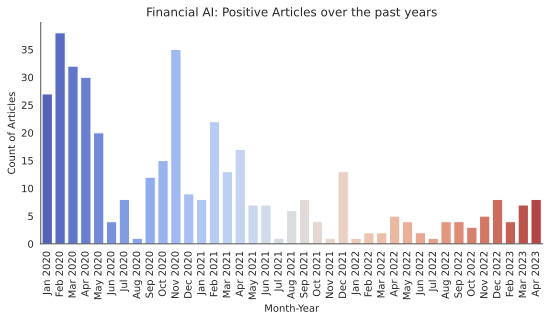

In [143]:
# Financial Sector

df_filt_pos_fin=df_filt_pos[df_filt_pos.Bert_topics.isin([10])]
pos_fin_period=df_filt_pos_fin.groupby(['year_pub','month','month-year'],as_index=False)['url'].agg('count')
pos_fin_period.rename(columns={'url':'count_articles'}, inplace=True)

coolwarm_palette = sns.color_palette('coolwarm', n_colors=len(articles_sents['month-year'].unique()))
fig,axes=plt.subplots(figsize=(9, 4))
sns.barplot(x=pos_fin_period['month-year'],y=pos_fin_period['count_articles'], ax=axes, palette=coolwarm_palette)

plt.xticks(rotation=90)
# Add labels and title if needed
plt.xlabel('Month-Year')
plt.ylabel('Count of Articles')
plt.title('Financial AI: Positive Articles over the past years')
sns.despine()
# Show the plot
plt.show()
fig.savefig('053_Figures/finai_pos.png')

In [144]:
import pandas as pd